# Check time join for ERA/MODIS


Our current appraoach for joining the ERA and MODIS data in time is to first select an hourly slice of MODIS data.

We do this as follows:

* Load a 24 hour file of MODIS data

* Map longitude to UTC, assuming a fixed local solar time of 13.30, rounded to nearest hour

* Select only times you are interested in e.g. all data with UTC = 11


There are also some additional considerations w.r.t the dateline if the time you are loading is outside of the min/max hours. For now we can ignore this subtlety 

---


The fundamental assumption here is that we can map longitude to time in this way. This assumption is true if all observations are taken at a fixed local solar time of 13.30 (for AquaDay). **Is this true?**


## 1. Load some data

Lets get a day of MODIS data. We will use the [MYD11C1](https://lpdaac.usgs.gov/products/myd11c1v061/) data product. See also [the docs](https://lpdaac.usgs.gov/documents/715/MOD11_User_Guide_V61.pdf).

In [1]:
! wget https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf -O /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/example_MODIS_data.hdf

--2022-03-21 17:08:25--  https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf
Resolving e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)... 152.61.133.130, 2001:49c8:4000:127d::133:130
Connecting to e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)|152.61.133.130|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2MS4yMDIxMzMwMDUyMzA2LmhkZg [following]
--2022-03-21 17:08:26--  https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2



---







We can then load this data and take a quick look:

In [1]:
import xarray as xr
import rioxarray as rxr

modis_xarray= rxr.open_rasterio('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/example_MODIS_data.hdf',masked=True)

ModuleNotFoundError: No module named 'rioxarray'

In [157]:
modis_xarray

<xarray.Dataset>
Dimensions:               (y: 3600, x: 7200, band: 1)
Coordinates:
  * y                     (y) float64 89.97 89.92 89.88 ... -89.88 -89.93 -89.98
  * x                     (x) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * band                  (band) int64 1
    spatial_ref           int64 0
Data variables: (12/21)
    LST_Day_CMG           (band, y, x) float32 nan nan nan nan ... nan nan nan
    Emis_22               (band, y, x) float32 ...
    Emis_23               (band, y, x) float32 ...
    Emis_29               (band, y, x) float32 ...
    Emis_31               (band, y, x) float32 ...
    Emis_32               (band, y, x) float32 ...
    ...                    ...
    Day_view_angl         (band, y, x) float32 ...
    LST_Night_CMG         (band, y, x) float32 ...
    QC_Night              (band, y, x) float32 ...
    Night_view_time       (band, y, x) float32 ...
    Night_view_angl       (band, y, x) float32 ...
    Emis_20               (band, y, x) float32 ...
Attributes: (12/51)
    ALGORITHMPACKAGENAME:               MOD_PR11C1
    ALGORITHMPACKAGEVERSION:            6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    AUTOMATICQUALITYFLAG.1:             Passed
    ...                                 ...
    SHORTNAME:                          MYD11C1
    SOUTHBOUNDINGCOORDINATE:            -90.0
    SPSOPARAMETERS:                     2484 and 3323
    VERSIONID:                          61
    WESTBOUNDINGCOORDINATE:             -180.0
    ZONEIDENTIFIER:                     Other Grid System

It is important to realise that here `Day_view_time` is the **UTC time** NOT the local solar time:

In [158]:
modis_xarray.Day_view_time

<xarray.DataArray 'Day_view_time' (band: 1, y: 3600, x: 7200)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  0.2
    add_offset:    0.0
    long_name:     Time of daytime LST observation (UTC)
    units:         hrs

We also have a `QC_Day` variable which is an interpretable bit string. See section 5.4 of https://lpdaac.usgs.gov/documents/715/MOD11_User_Guide_V61.pdf

In [238]:
def convert_to_bit_string(x):
    
    s = int(x)
    
    return f'0b{s:08b}'

## 2. Tidy up data

We are not interested in all the variables. Lets grab just the day view temperature and time, along with the lat/lon position and the quality bit string, which we will expand

In [275]:
modis_df = modis_xarray[['LST_Day_CMG','Day_view_time','QC_Day']].to_dataframe().reset_index().dropna().drop(['band','spatial_ref'],axis=1)

In [276]:
modis_df['bit_string'] =  modis_df['QC_Day'].apply(convert_to_bit_string)


In [277]:
modis_df['QA_flags'] = modis_df['bit_string'].apply(lambda x: x[2:4])
modis_df['DQ_flags'] = modis_df['bit_string'].apply(lambda x: x[4])
modis_df['CU_flags'] = modis_df['bit_string'].apply(lambda x: x[5])
modis_df['Emis_flags'] = modis_df['bit_string'].apply(lambda x: x[6:8])
modis_df['LST_flags'] = modis_df['bit_string'].apply(lambda x: x[8:10])

In [278]:
modis_df

y       x  LST_Day_CMG  Day_view_time  QC_Day  bit_string  \
910125    83.675 -33.725      12387.0           53.0     8.0  0b00001000   
910126    83.675 -33.675      12387.0           53.0     8.0  0b00001000   
910127    83.675 -33.625      12387.0           53.0     8.0  0b00001000   
910128    83.675 -33.575      12387.0           53.0     8.0  0b00001000   
910129    83.675 -33.525      12387.0           53.0     8.0  0b00001000   
...          ...     ...          ...            ...     ...         ...   
25871667 -89.675 -76.625      11220.0          113.0    65.0  0b01000001   
25871668 -89.675 -76.575      11220.0          113.0    65.0  0b01000001   
25871669 -89.675 -76.525      11220.0          113.0    65.0  0b01000001   
25871670 -89.675 -76.475      11220.0          113.0    65.0  0b01000001   
25871671 -89.675 -76.425      11220.0          112.0    65.0  0b01000001   

         QA_flags DQ_flags CU_flags Emis_flags LST_flags  
910125         00        0        0         10        00  
910126         00        0        0         10        00  
910127         00        0        0         10        00  
910128         00        0        0         10        00  
910129         00        0        0         10        00  
...           ...      ...      ...        ...       ...  
25871667       01        0        0         00        01  
25871668       01        0        0         00        01  
25871669       01        0        0         00        01  
25871670       01        0        0         00        01  
25871671       01        0        0         00        01  

[4952643 rows x 11 columns]

And create some useful columns

In [280]:
modis_df['temperature_kelvin'] = modis_df['LST_Day_CMG']*modis_xarray.LST_Day_CMG.scale_factor
modis_df['UTC'] = modis_df['Day_view_time']*modis_xarray.Day_view_time.scale_factor
modis_df['UTC_hr'] = round(modis_df.UTC) 
modis_df['UTC_theoretical'] = round(13.5 - modis_df.x/15)                           # this is how we currently define the absolute time
modis_df['UTC_error'] = modis_df.UTC_hr - modis_df.UTC_theoretical              #and the error

In practice we know there are issues at the "edges" i.e. extrema of longitude and also at the poles. Lets restrict our analysis to a subset of the globe:

In [281]:
modis_df_filtered = modis_df.query('-70 < y < 70').copy()

We can also use the quality filter to create a high and low quality dataset:

In [282]:
modis_df_HQ = modis_df_filtered.query('LST_flags == "00" & DQ_flags == "0"')
modis_df_LQ = modis_df_filtered.copy()

## 3. Make some plots

In [273]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.colorbar as cb 
def plot_map(df,z,vmin,vmax,cmap):
    
    
    """
    Hacky plotting function that just plots as scatter
    """
    
    x = df.x.values
    y = df.y.values
    z1 = df[z].values

    
    #Scatter plot it
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
    
    
    sc = ax.scatter(x, y,s=1,c=cmap(norm(z1)),linewidths=1, alpha=1)

    ax.set_xlim(-180,180)
    ax.set_ylim(-70,70)

    ax.set_title(z)
    plt.show()
    
    
    

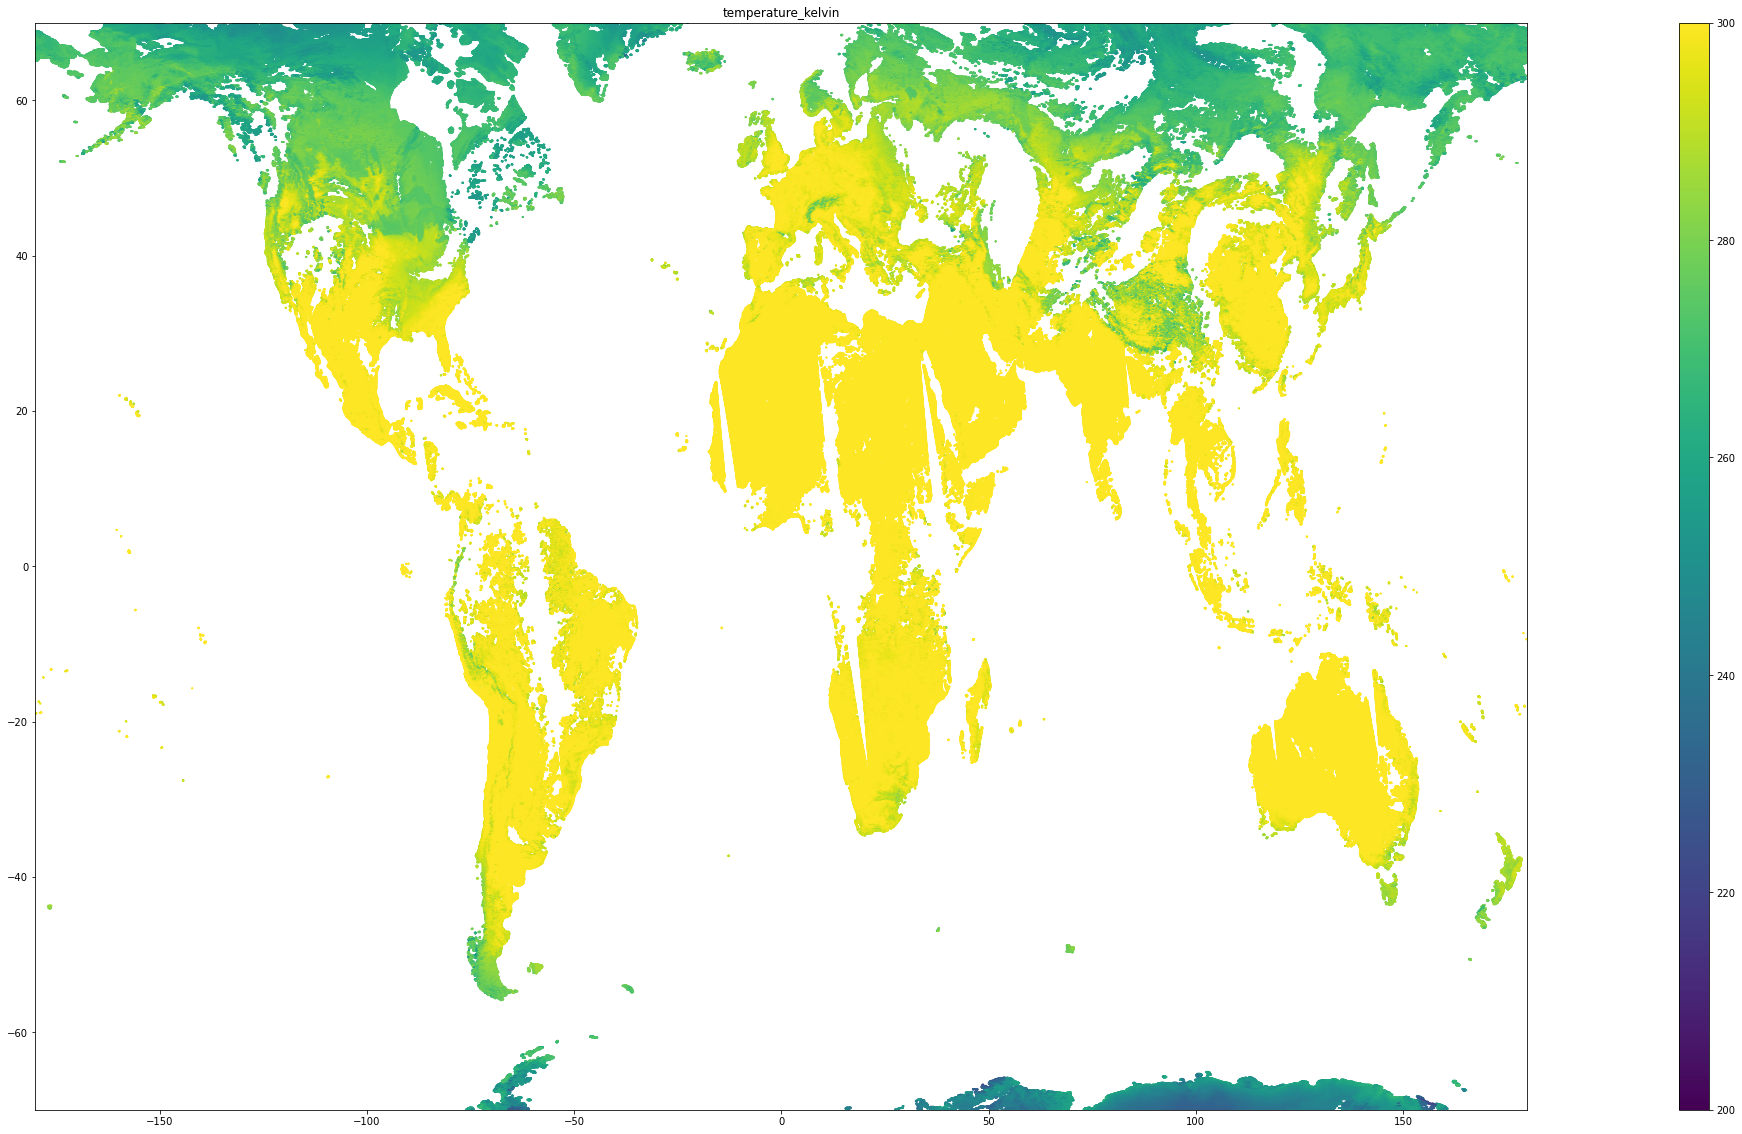

In [285]:
plot_map(modis_df_LQ,'temperature_kelvin',vmin=200,vmax=300,cmap=plt.cm.viridis)

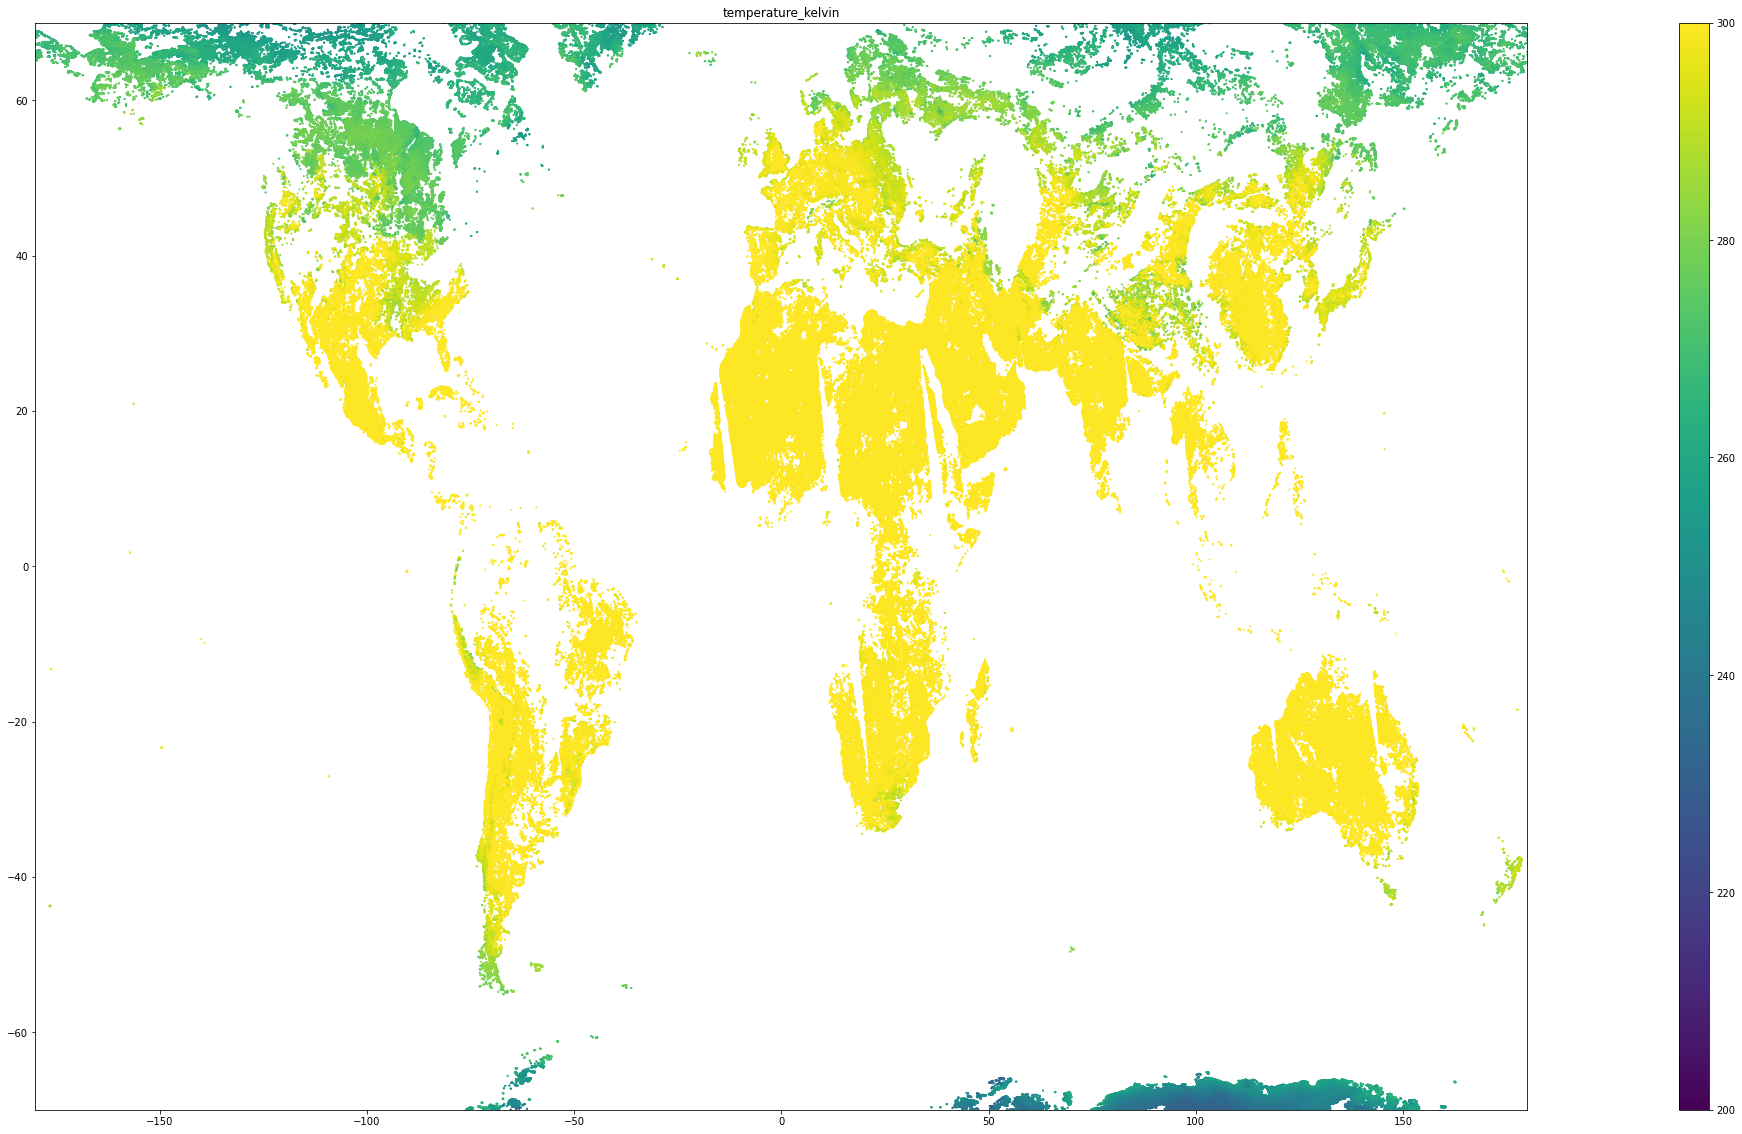

In [286]:
plot_map(modis_df_HQ,'temperature_kelvin',vmin=200,vmax=300,cmap=plt.cm.viridis)

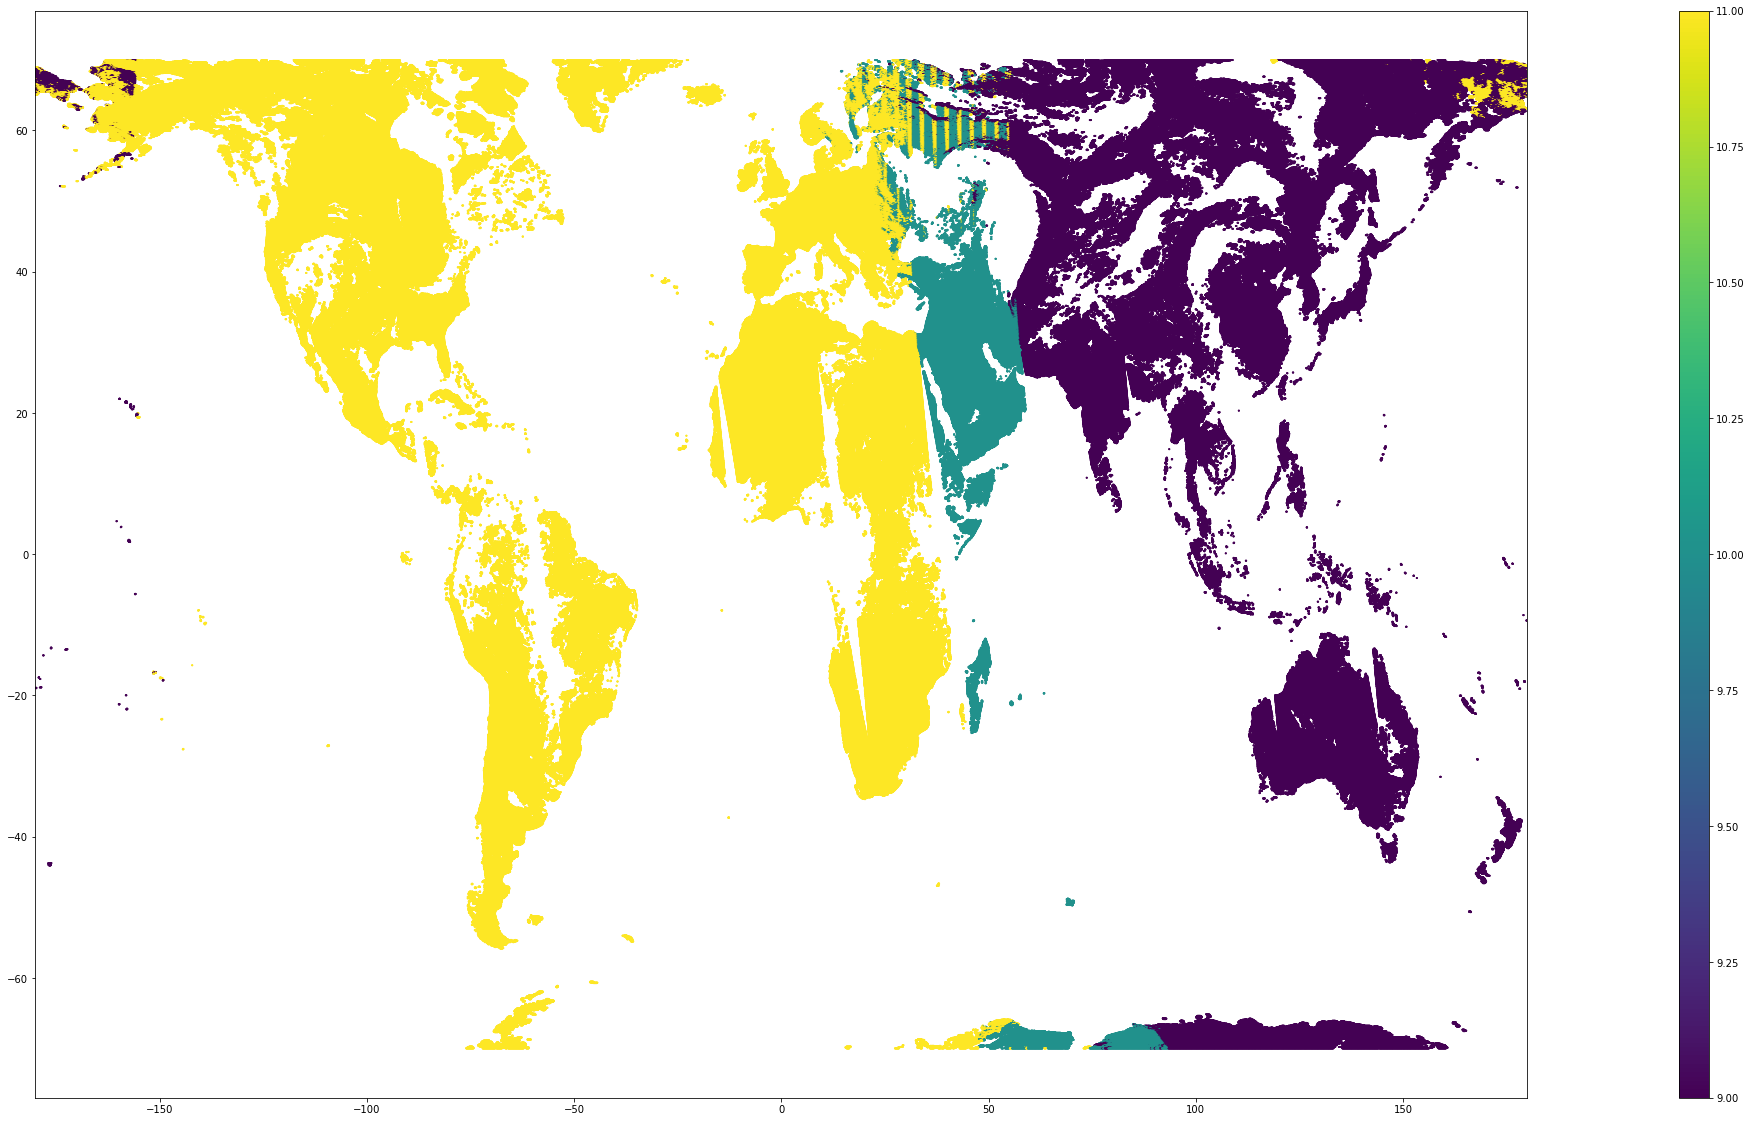

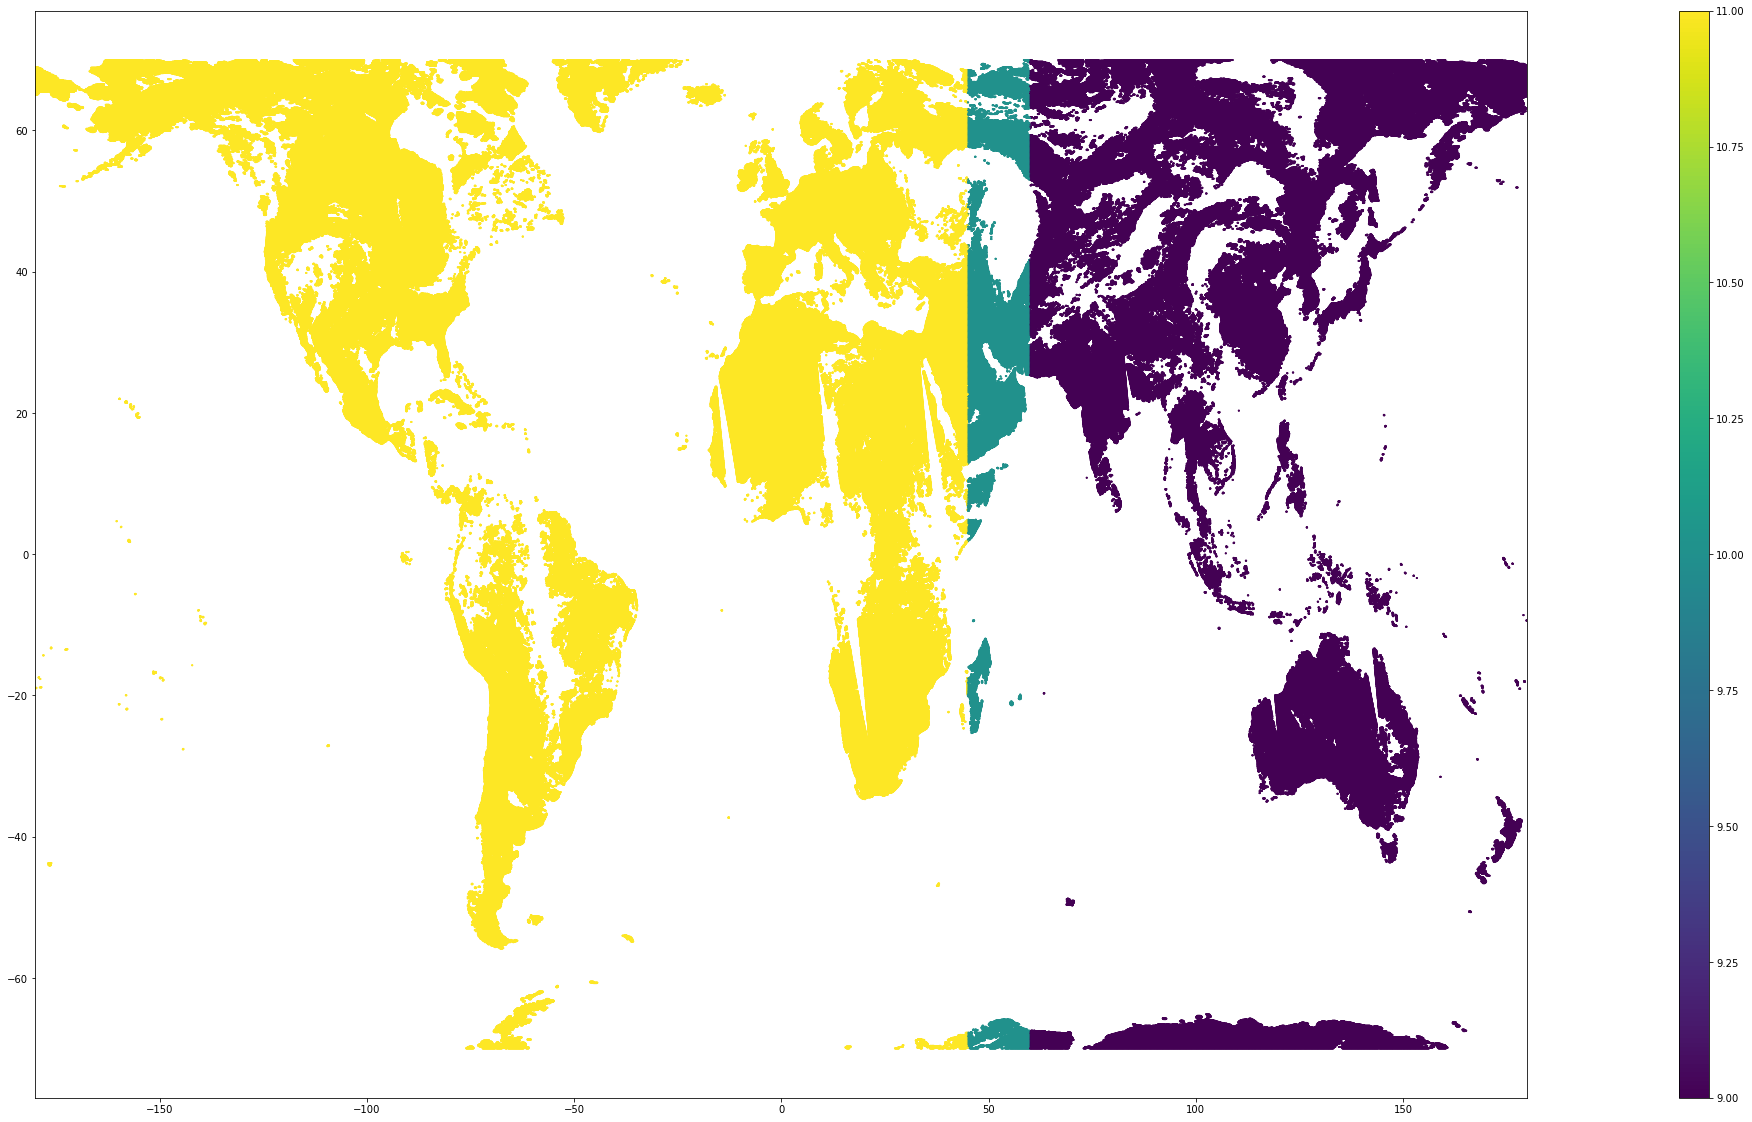

In [215]:
plot_map(modis_df_filtered,'UTC_hr',vmin=9,vmax=11,cmap=plt.cm.viridis)
plot_map(modis_df_filtered,'UTC_theoretical',vmin=9,vmax=11,cmap=plt.cm.viridis)
#plot_map(modis_df_filtered,'UTC_error',vmin=-10,vmax=+10,cmap=plt.cm.bwr)



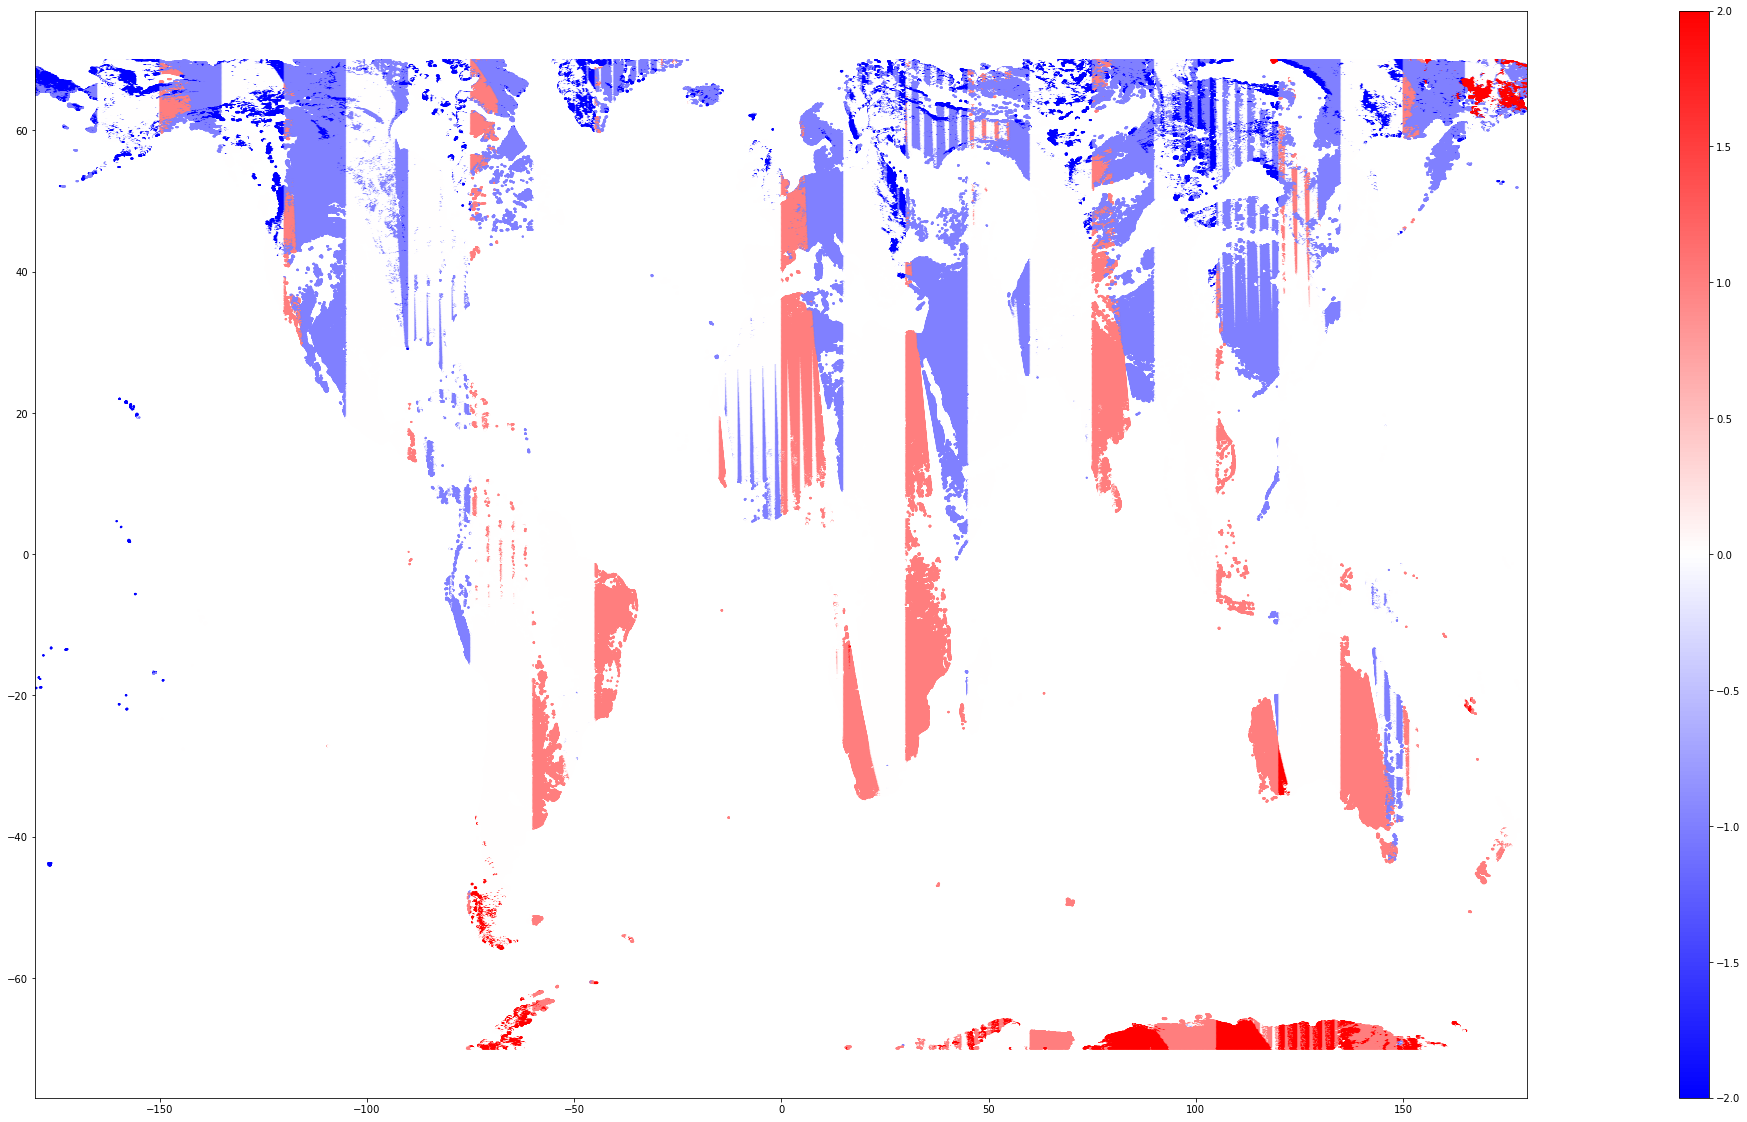

In [211]:
plot_map(modis_df_filtered,'UTC_error',vmin=-2,vmax=+2,cmap=plt.cm.bwr)



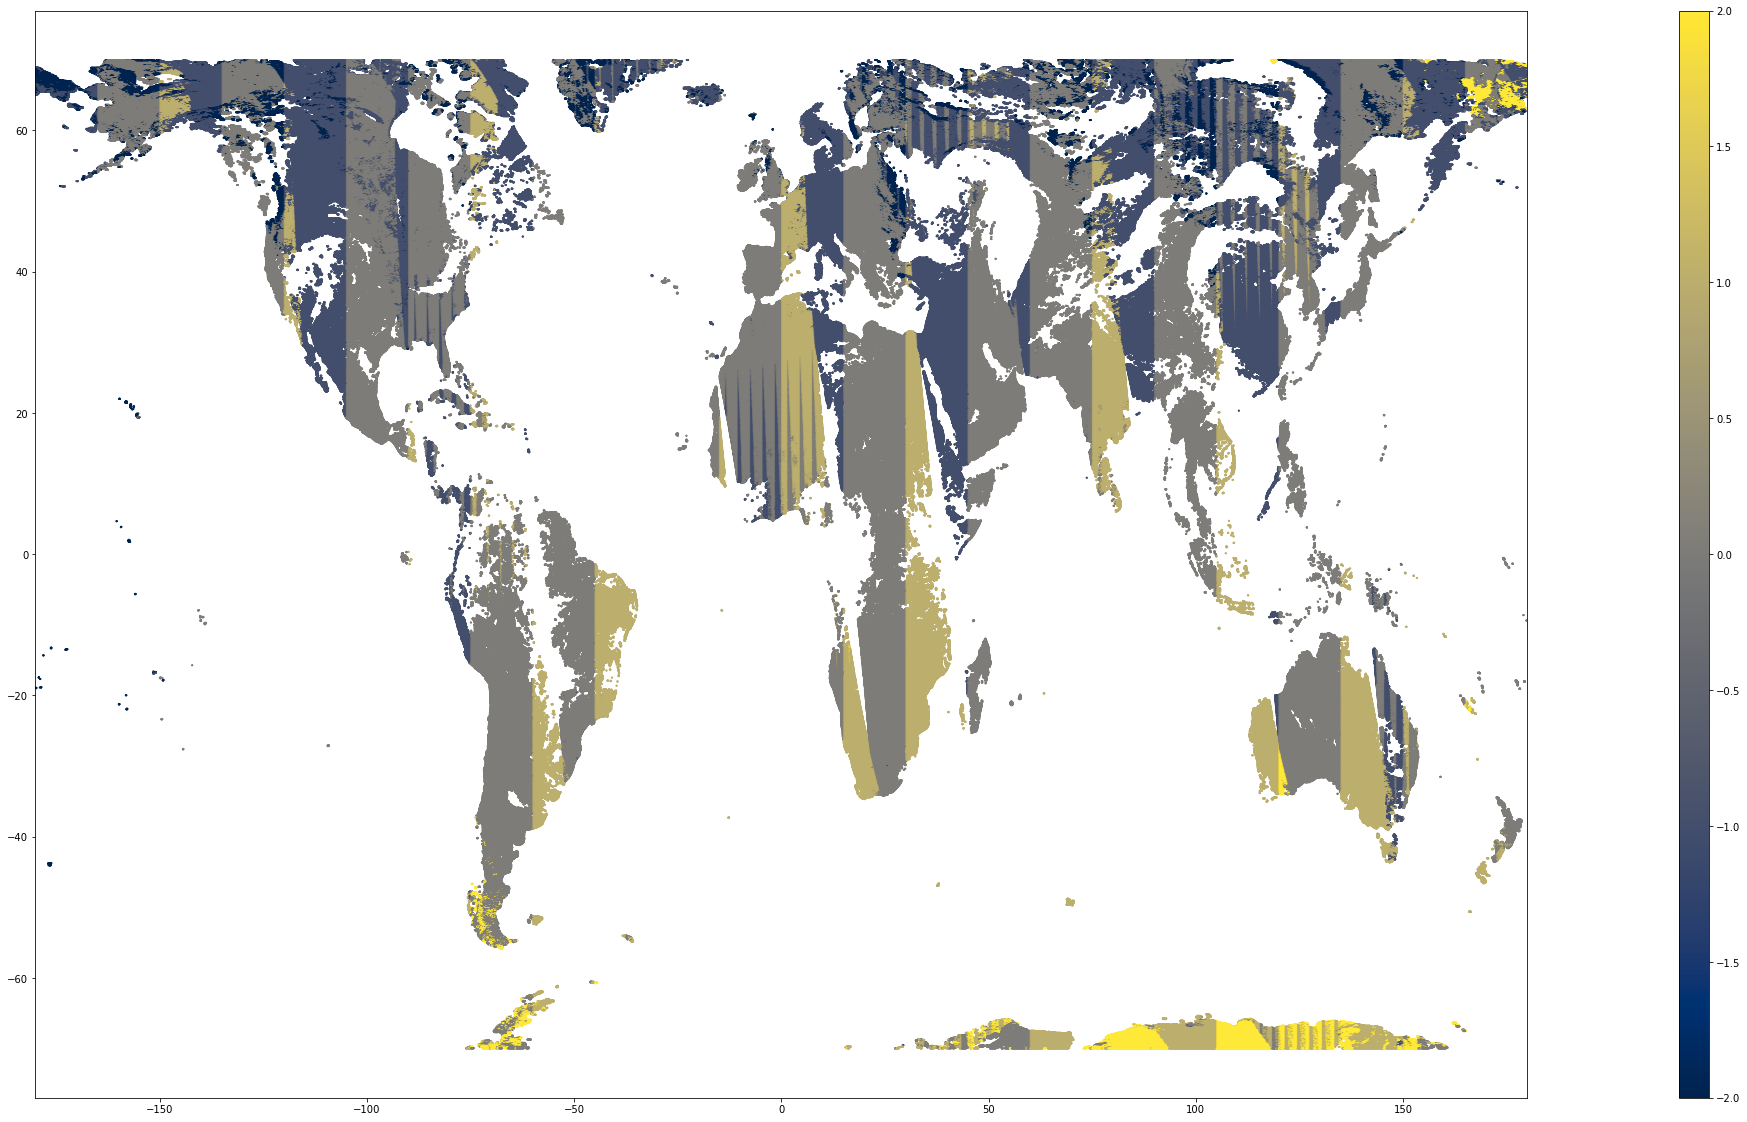

In [217]:
plot_map(modis_df_filtered,'UTC_error',vmin=-2,vmax=+2,cmap=plt.cm.cividis)



What are the implications? If we want to grab a slice of data at  

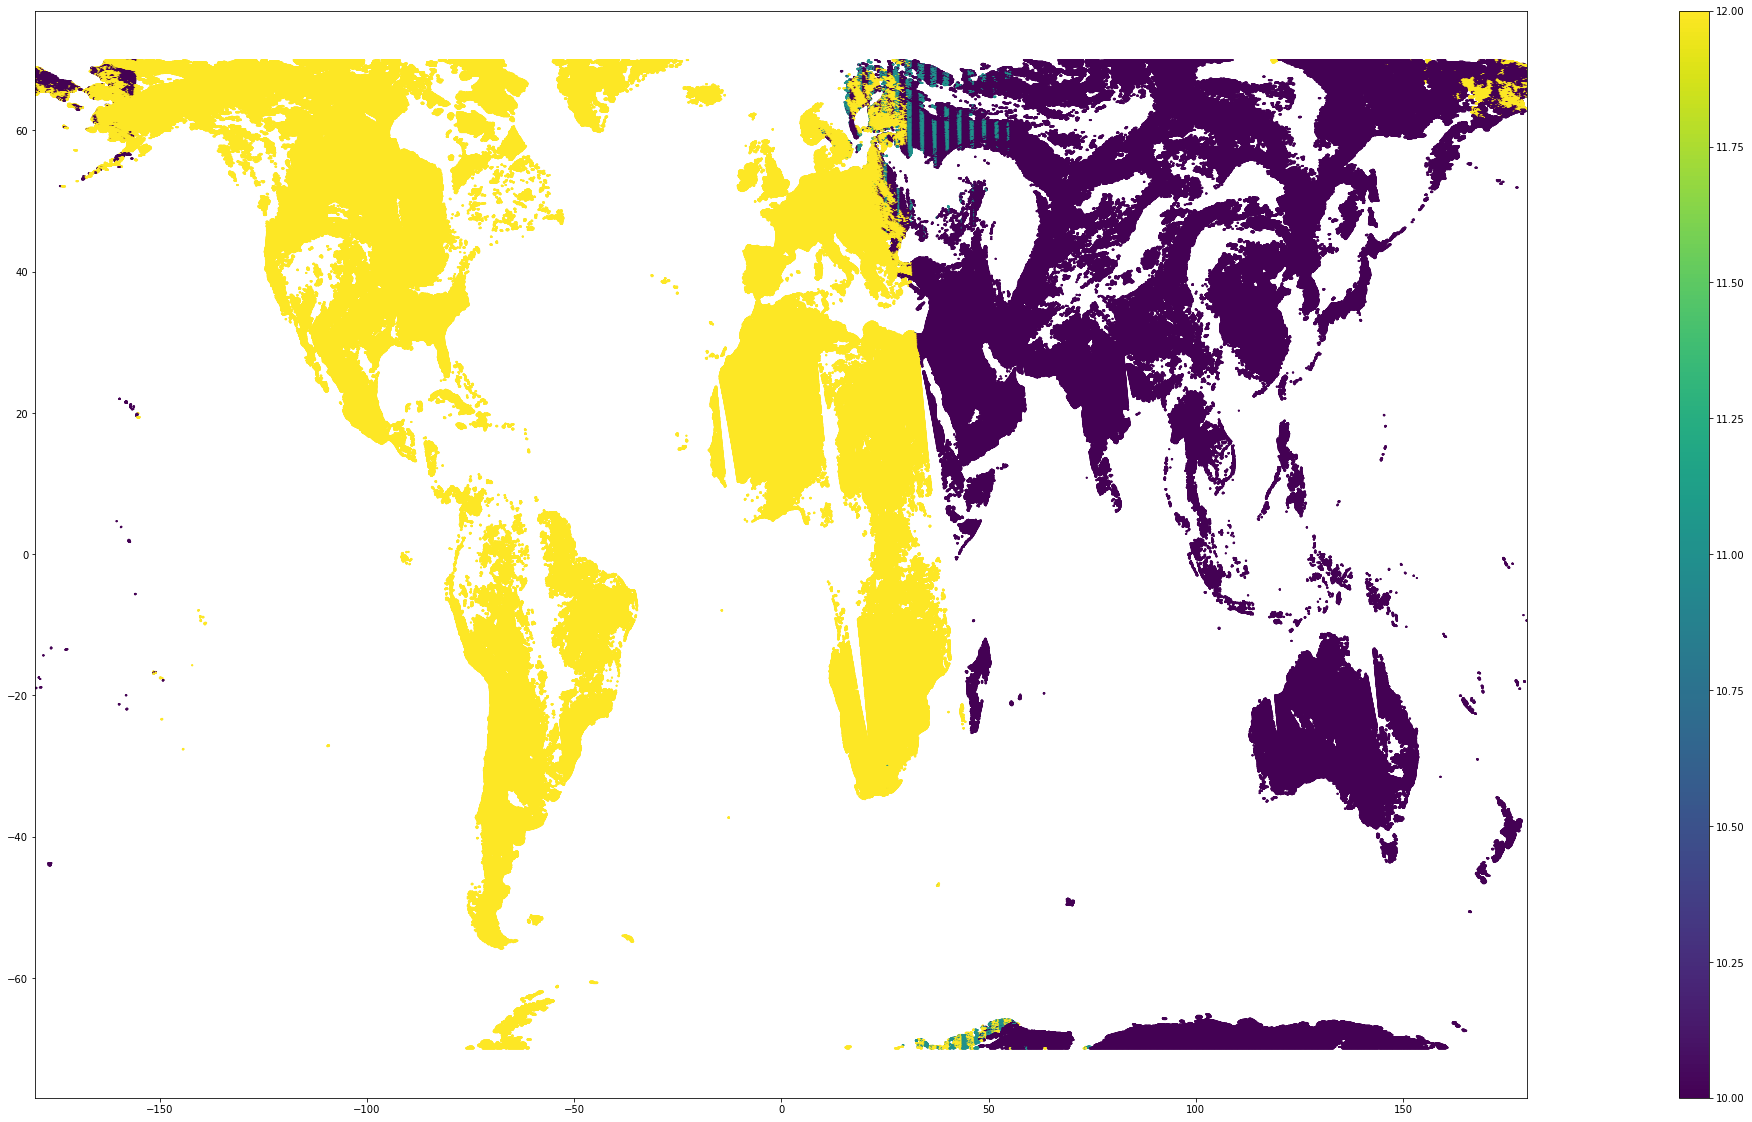

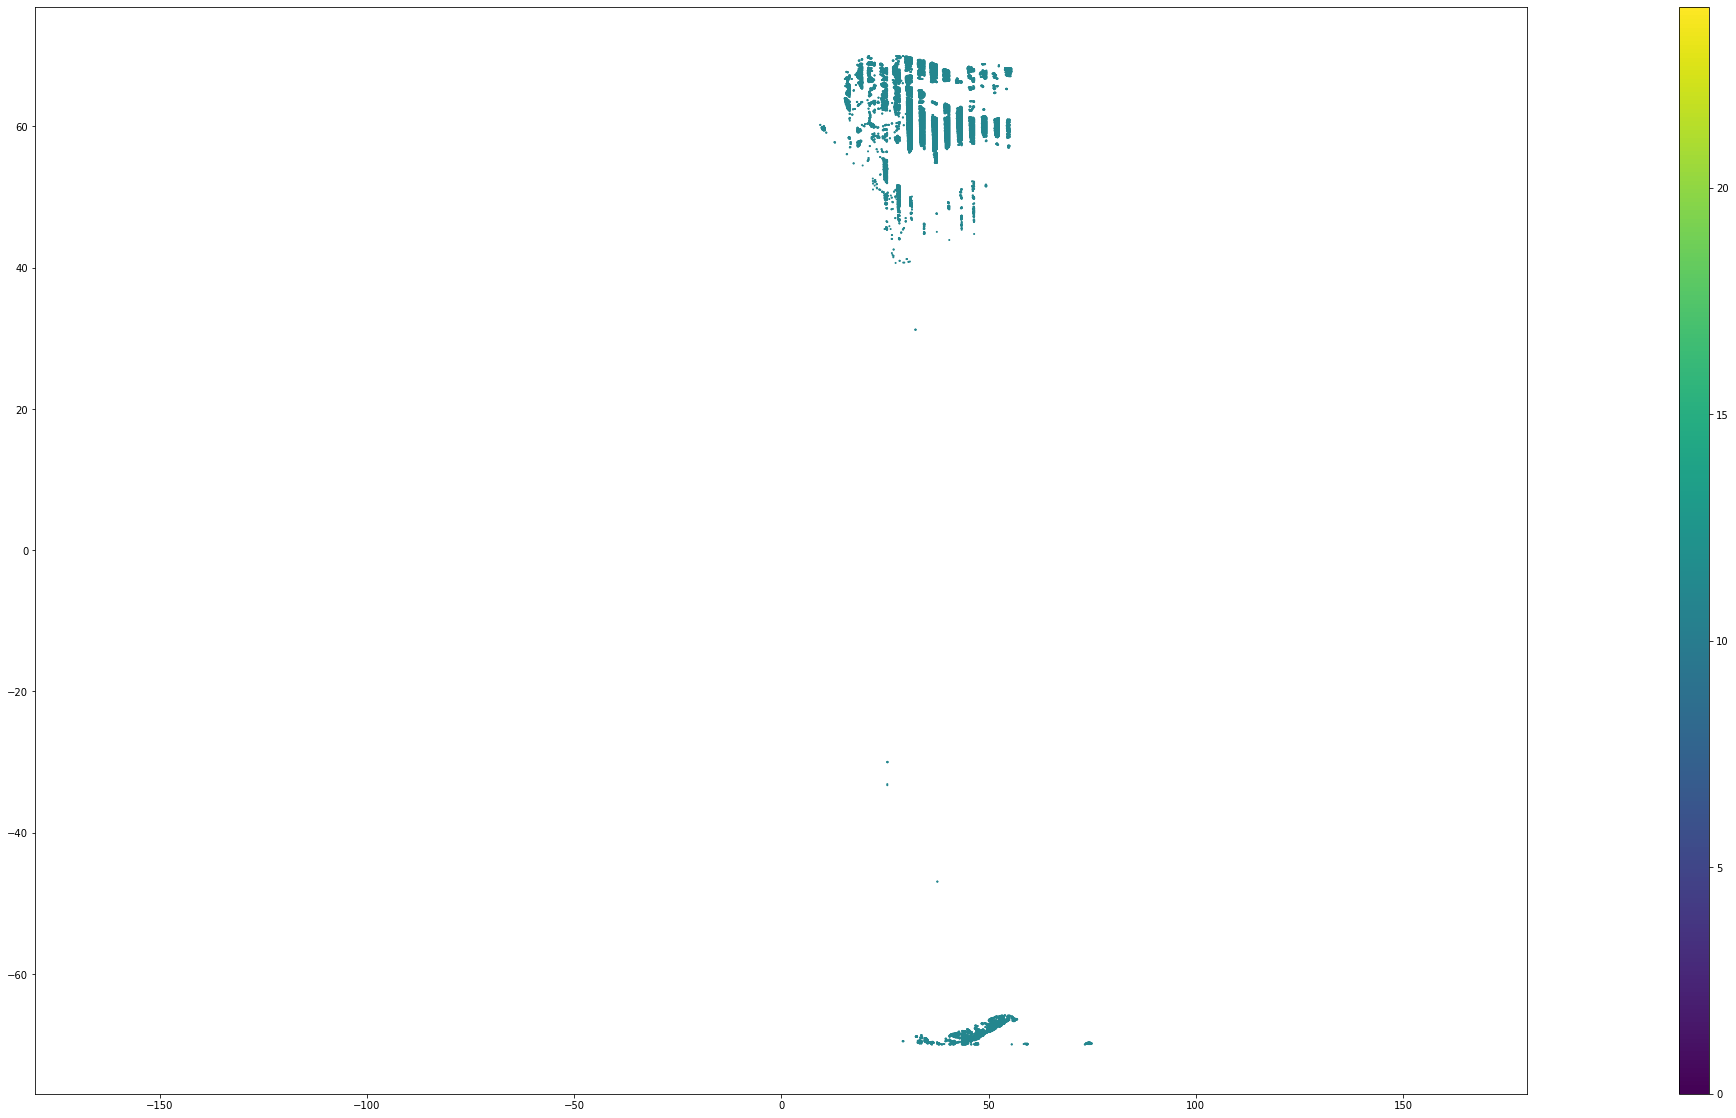

In [200]:
M = modis_df_filtered.query('UTC_hr == 11')
plot_map(modis_df_filtered,'UTC_hr',vmin=10,vmax=+12,cmap=plt.cm.viridis)
plot_map(M,'UTC_hr',vmin=0,vmax=+24,cmap=plt.cm.viridis)